### Setup

Make sure you have the files available from previous demos.

In [0]:
# This cell sets all the configuration parameters to connect to Azure Data Lake
spark.conf.set("fs.azure.account.auth.type.<account_name>.dfs.core.windows.net", "OAuth")
spark.conf.set("fs.azure.account.oauth.provider.type.<account_name>.dfs.core.windows.net", "org.apache.hadoop.fs.azurebfs.oauth2.ClientCredsTokenProvider")
spark.conf.set("fs.azure.account.oauth2.client.id.<account_name>.dfs.core.windows.net", "****************************")
spark.conf.set("fs.azure.account.oauth2.client.secret.<account_name>.dfs.core.windows.net", "*******************************")
spark.conf.set("fs.azure.account.oauth2.client.endpoint.<account_name>.dfs.core.windows.net", "https://login.microsoftonline.com/************************/oauth2/token")

Verify that cloud storage is accessible

In [0]:
dbutils.fs.ls("abfss://pyspark@warnerdatalake.dfs.core.windows.net/")

[FileInfo(path='abfss://pyspark@warnerdatalake.dfs.core.windows.net/exports/', name='exports/', size=0, modificationTime=1740581924000),
 FileInfo(path='abfss://pyspark@warnerdatalake.dfs.core.windows.net/imports/', name='imports/', size=0, modificationTime=1740581918000)]

Let's load our dataset

In [0]:
from pyspark.sql import functions as F

# Paths to datasets
transactions_path = "abfss://pyspark@warnerdatalake.dfs.core.windows.net//imports//transactions_data.parquet"
customers_path = "abfss://pyspark@warnerdatalake.dfs.core.windows.net//imports//customers_data.parquet"

# Load DataFrames
df_transactions = spark.read.parquet(transactions_path)
df_customers = spark.read.parquet(customers_path)

# Display sample data
df_transactions.limit(5).display()
df_customers.limit(5).display()



transaction_id,customer_id,transaction_date,amount,category
1,3065,2025-03-17,76.10,Clothes
2,3274,2025-02-18,91.91,Clothes
3,130,2025-01-10,11.81,Accessories
4,320,2025-03-06,20.37,Furniture
5,6480,2025-03-22,12.31,Beauty


customer_id,first_name,last_name,email,age,country
1,First_1,Last_1,First_1.Last_1@example.com,40,Canada
2,First_2,Last_2,First_2.Last_2@example.com,55,USA
3,First_3,Last_3,First_3.Last_3@example.com,59,USA
4,First_4,Last_4,First_4.Last_4@example.com,49,Canada
5,First_5,Last_5,First_5.Last_5@example.com,58,Canada


Let's join the dataframes and calculate some aggregations

In [0]:
# Join the two DataFrames on customer_id
df_joined = df_customers.join(df_transactions, on="customer_id", how="inner")

# Aggregate the joined data:
#   - Count the number of transactions per customer
#   - Calculate the average transaction amount
#   - Determine the first and last transaction dates
df_agg = df_joined.groupBy("customer_id", "email").agg(
    F.count("transaction_id").alias("total_transactions"),
    F.avg("amount").alias("avg_transaction_amount"),
    F.min("transaction_date").alias("first_transaction_date"),
    F.max("transaction_date").alias("last_transaction_date")
)

# Grab the top 10
df_top_customers = df_agg.orderBy(F.desc("total_transactions")).limit(10)
df_top_customers.limit(10).display()

customer_id,email,total_transactions,avg_transaction_amount,first_transaction_date,last_transaction_date
550,First_550.Last_550@example.com,138,53.767971,2025-01-01,2025-03-31
1018,First_1018.Last_1018@example.com,136,51.547279,2025-01-02,2025-03-31
5091,First_5091.Last_5091@example.com,136,50.626471,2025-01-01,2025-03-30
7911,First_7911.Last_7911@example.com,135,49.055407,2025-01-03,2025-03-31
5973,First_5973.Last_5973@example.com,135,52.480000,2025-01-01,2025-03-30
2820,First_2820.Last_2820@example.com,134,51.998358,2025-01-01,2025-03-28
9457,First_9457.Last_9457@example.com,133,52.046917,2025-01-01,2025-03-31
8630,First_8630.Last_8630@example.com,133,54.135263,2025-01-01,2025-03-30
33,First_33.Last_33@example.com,133,48.841880,2025-01-01,2025-03-31
4512,First_4512.Last_4512@example.com,132,45.600758,2025-01-01,2025-03-31


To use popular Python visuals libraries, we convert to Pandas

In [0]:
# Convert the Spark DataFrame to a pandas DataFrame
df_pandas = df_top_customers.toPandas()


/databricks/spark/python/pyspark/sql/pandas/utils.py:149: UserWarning: The conversion of DecimalType columns is inefficient and may take a long time. Column names: [avg_transaction_amount] If those columns are not necessary, you may consider dropping them or converting to primitive types before the conversion.
  warnings.warn(


Now let's create a visual with matplotlib

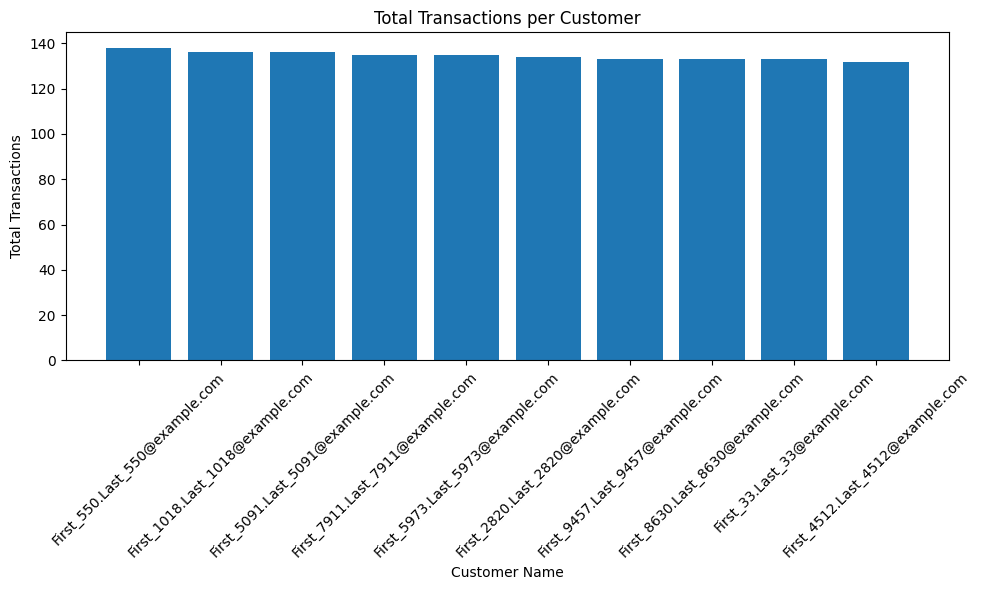

In [0]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(df_pandas['email'], df_pandas['total_transactions'])
plt.xlabel('Customer Name')
plt.ylabel('Total Transactions')
plt.title('Total Transactions per Customer')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


We can try with Plotly Express

In [0]:
import plotly.express as px

# Create an interactive scatter plot using Plotly Express
fig = px.scatter(
    df_pandas,
    x="total_transactions",
    y="avg_transaction_amount",
    text="email",
    title="Avg Transaction Amount vs Total Transactions"
)
fig.update_traces(textposition='top center')
fig.show()


Let's do another one with seaborn

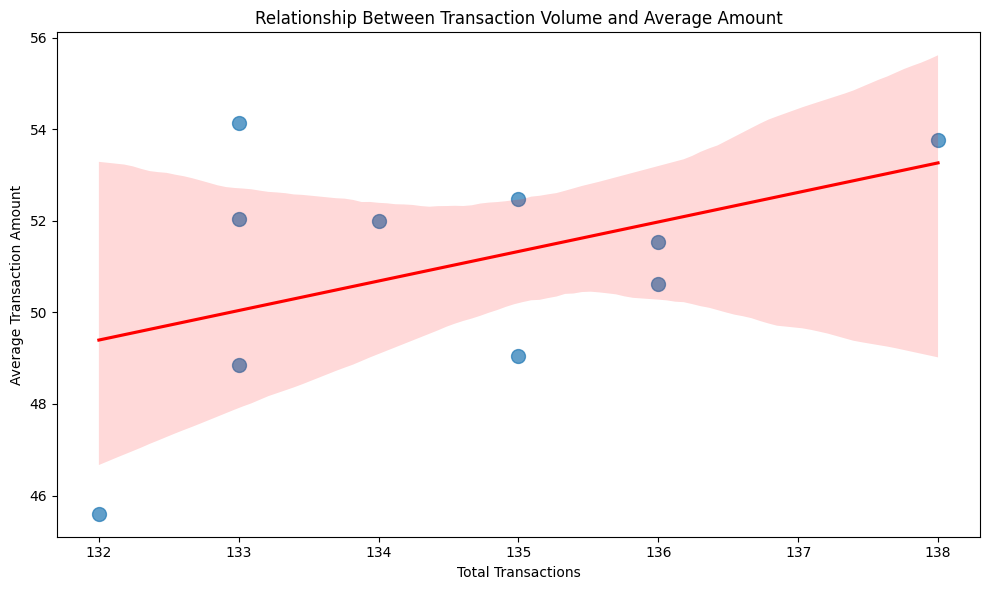

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convert decimal.Decimal columns to float
df_pandas["total_transactions"] = df_pandas["total_transactions"].astype(float)
df_pandas["avg_transaction_amount"] = df_pandas["avg_transaction_amount"].astype(float)

plt.figure(figsize=(10, 6))
sns.regplot(
    x="total_transactions",
    y="avg_transaction_amount",
    data=df_pandas,
    scatter_kws={"s": 100, "alpha": 0.7},
    line_kws={"color": "red"}
)
plt.xlabel("Total Transactions")
plt.ylabel("Average Transaction Amount")
plt.title("Relationship Between Transaction Volume and Average Amount")
plt.tight_layout()
plt.show()

And you can of course export any of the dataframes back out to cloud storage

In [0]:
df_top_customers.write.format("delta").mode("overwrite").save("abfss://pyspark@warnerdatalake.dfs.core.windows.net/exports/top_customers")